In [3]:
import sys, pathlib
import pandas as pd
import numpy as np
import joblib

# Ruta al proyecto
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg
from src import evol_utils as eu
from sklearn.preprocessing import StandardScaler

# === Paths dinámicos ===
if cfg.MODEL_TYPE == "lstm":
    MODEL_PATH = cfg.MODELS / cfg.LSTM_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"
elif cfg.MODEL_TYPE == "lstm5d":
    MODEL_PATH = cfg.MODELS / cfg.LSTM5D_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm5d_data.pkl"
elif cfg.MODEL_TYPE == "gru5d":
    MODEL_PATH = cfg.MODELS / cfg.GRU5D_MODEL_NAME
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "xgb":
    MODEL_PATH = cfg.MODELS / cfg.XGB_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "xgb_data.pkl"
elif cfg.MODEL_TYPE == "cnn5d":
    MODEL_PATH = cfg.MODELS / "cnn5d.keras"
    DATA_PATH = cfg.DATA / "processed" / "cnn5d_data.pkl"
    scaler_cnn5d = joblib.load(cfg.MODELS / "scaler_X_cnn5d.pkl")


else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

PRICES_PATH = cfg.DATA / "raw" / "prices.parquet"

print(f"🧠 Modelo activo: {cfg.MODEL_TYPE}")

🧠 Modelo activo: cnn5d


In [5]:
# === Datos ===
df_prices = pd.read_parquet(PRICES_PATH).sort_index()
lstm_data = joblib.load(DATA_PATH)
tickers = lstm_data["tickers"]
df_prices = df_prices[tickers]
df_ret = np.log(df_prices / df_prices.shift(1)).dropna()

# Momentum + features
ret5 = df_ret.rolling(5).sum()
vol5 = df_ret.rolling(5).std()
momentum = (ret5 / vol5).shift(1)
df_feat = pd.concat([df_ret.shift(1), momentum], axis=1).dropna()

print("✅ df_feat shape:", df_feat.shape)

# === Cargar modelo y escalador ===
if cfg.MODEL_TYPE in ["lstm", "lstm5d","cnn5d"]:
    from tensorflow import keras
    model = keras.models.load_model(MODEL_PATH, compile=False)
elif cfg.MODEL_TYPE == "gru5d":
    from tensorflow import keras
    model = keras.models.load_model(cfg.MODELS / cfg.GRU5D_MODEL_NAME, compile=False)
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "xgb":
    model = joblib.load(MODEL_PATH)
else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

# Solo para lstm5d
if cfg.MODEL_TYPE == "lstm5d":
    scaler_lstm5d = joblib.load(cfg.MODELS / "scaler_X_lstm5d.pkl")

✅ df_feat shape: (1495, 80)


In [7]:
from src import config as cfg
import joblib

ruta = cfg.MODELS / "scaler_y_lstm.pkl"
print("📦 Escalador existe:", ruta.exists())


📦 Escalador existe: True


In [19]:
# ───────────────────────────────────────────────────────────────────────────────
# rebalanceo.py  – función rebalancear_en_fecha  (versión SIN warnings)
# ───────────────────────────────────────────────────────────────────────────────
import joblib, numpy as np, pandas as pd, src.evol_utils as eu  # resto igual …

def _lazy_loader(var_name, pkl_path):
    if var_name not in globals():
        globals()[var_name] = joblib.load(pkl_path)
    return globals()[var_name]


def rebalancear_en_fecha(fecha, df_feat, model, w_prev=None):
    try:
        idx     = df_feat.index.get_loc(fecha)
        ventana = df_feat.iloc[idx - cfg.WINDOW: idx]

        # ── 1. PREDICCIÓN ───────────────────────────────────────────────────
        if cfg.MODEL_TYPE == "lstm":
            ventana  = ventana.iloc[:, :len(tickers)]
            scaler_X = _lazy_loader("scaler_X_lstm",  cfg.MODELS / "scaler_X_lstm.pkl")
            X_scaled = scaler_X.transform(ventana.values)      # ← AÑADIDO .values
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_lstm",  cfg.MODELS / "scaler_y_lstm.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]
            r_hat = np.clip(r_hat, -0.08, 0.08)

        elif cfg.MODEL_TYPE == "lstm5d":
            scaler_X = _lazy_loader("scaler_X_lstm5d", cfg.MODELS / "scaler_X_lstm5d.pkl")
            X_scaled = scaler_X.transform(ventana.values)      # ← .values
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_lstm5d", cfg.MODELS / "scaler_y_lstm5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]
                     # ─── ajuste especial 5-días  ─────────────────────────
            r_hat = r_hat / 5.0            
            r_hat = np.clip(r_hat, -0.08, 0.08)

        elif cfg.MODEL_TYPE == "cnn5d":
            scaler_X = _lazy_loader("scaler_X_cnn5d", cfg.MODELS / "scaler_X_cnn5d.pkl")
            X_scaled = scaler_X.transform(ventana.values)          # shape: (W, 160)
            n_assets = len(tickers)        # 80
            n_chan   = 2                   # [ret , momentum]
            X_input  = X_scaled.reshape(1, cfg.WINDOW, n_assets, n_chan)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_cnn5d", cfg.MODELS / "scaler_y_cnn5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]   # vuelve a puntos %
            r_hat    = r_hat / 5.0                              # de 5-d → 1-d
            r_hat    = np.clip(r_hat, -0.12, 0.12)              # safety-clip ±12 %

        elif cfg.MODEL_TYPE == "gru5d":
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            ret5        = df_ret.rolling(5).sum()
            vol5        = df_ret.rolling(5).std()
            momentum    = (ret5 / (vol5 + 1e-6)).shift(1)
            ventana_mom = momentum.loc[ventana_ret.index]
            ventana     = pd.concat([ventana_ret, ventana_mom], axis=1)

            scaler_X = _lazy_loader("scaler_X_gru5d", cfg.MODELS / "scaler_X_gru5d.pkl")
            X_scaled = scaler_X.transform(ventana.values)      # ← .values
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_gru5d", cfg.MODELS / "scaler_y_gru5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]

        elif cfg.MODEL_TYPE == "xgb":
            X_input = ventana.values                          # XGB sin escalar
            r_hat   = np.array([model[i].predict(X_input[-1].reshape(1, -1))[0]
                                for i in range(X_input.shape[1])])
        else:
            raise ValueError("Tipo de modelo no reconocido")

        # ── 2. OPTIMIZACIÓN (sin cambios) ──────────────────────────────────
        fecha_ret   = df_feat.index[idx]
        ventana_ret = df_ret.loc[:fecha_ret - pd.Timedelta(days=1)].tail(cfg.WINDOW)
        Sigma       = ventana_ret.cov().values

        if r_hat.shape[0] != Sigma.shape[0]:
            print(f"⚠️ Dim mismatch {fecha.date()}")
            return None

        res     = eu.resolver_optimizacion(r_hat, Sigma, w_prev=w_prev)
        w_star  = eu.elegir_w_star(res, r_hat, Sigma, w_prev=w_prev)

        turnover  = np.sum(np.abs(w_star - w_prev)) if w_prev is not None else 1.0
        ret_bruto = df_ret.iloc[idx: idx + cfg.REBAL_FREQ].values @ w_star
        ret_neto  = ret_bruto.sum() - turnover * cfg.COST_TRADE

        return {
            "fecha"    : fecha,
            "r_hat"    : r_hat,
            "ret_bruto": ret_bruto.sum(),
            "ret_neto" : ret_neto,
            "turnover" : turnover,
            "w_star"   : w_star,
        }

    except Exception as e:
        print(f"ERROR {fecha.date()}: {e}")
        return None


In [21]:
fechas = df_feat.loc[cfg.START_BACKTEST:].index
resultados = []
w_prev = None                       # sin cartera previa en t₀

for i in range(cfg.WINDOW, len(fechas) - cfg.REBAL_FREQ, cfg.REBAL_FREQ):
    fecha = fechas[i]
    out = rebalancear_en_fecha(fecha, df_feat, model, w_prev=w_prev)

    if out is not None:
        resultados.append(out)

        turno_log = 0.0 if w_prev is None else np.sum(np.abs(out["w_star"] - w_prev))

        print(f"✅ {fecha.date()} | Ret bruto {out['ret_bruto']:.4%} | "
              f"neto {out['ret_neto']:.4%} | turnover {turno_log:.2%}")

        w_prev = out["w_star"]      # cartera para el próximo ciclo
    else:
        print(f"⚠️ {fecha.date()} | Resultado nulo")


✅ 2023-10-20 | Ret bruto 1.0219% | neto 0.8219% | turnover 0.00%
✅ 2023-11-08 | Ret bruto 1.1212% | neto 1.0409% | turnover 40.16%
✅ 2023-11-29 | Ret bruto 0.1555% | neto 0.0722% | turnover 41.66%
✅ 2023-12-15 | Ret bruto 11.9963% | neto 11.9080% | turnover 44.15%
✅ 2024-01-05 | Ret bruto 3.0977% | neto 3.0157% | turnover 41.02%
✅ 2024-01-25 | Ret bruto 0.9883% | neto 0.9183% | turnover 35.00%
✅ 2024-02-13 | Ret bruto 1.1982% | neto 1.1187% | turnover 39.76%
✅ 2024-03-01 | Ret bruto 1.8488% | neto 1.7574% | turnover 45.73%
✅ 2024-03-20 | Ret bruto -1.7829% | neto -1.8500% | turnover 33.56%
✅ 2024-04-09 | Ret bruto -2.0979% | neto -2.1799% | turnover 41.01%
✅ 2024-04-25 | Ret bruto -2.8356% | neto -2.9225% | turnover 43.46%
✅ 2024-05-14 | Ret bruto 2.6059% | neto 2.5162% | turnover 44.83%
✅ 2024-05-31 | Ret bruto 0.8984% | neto 0.8225% | turnover 37.97%
✅ 2024-06-21 | Ret bruto 2.1379% | neto 2.0652% | turnover 36.36%
✅ 2024-07-12 | Ret bruto 1.7083% | neto 1.6284% | turnover 39.95%
✅ 2

In [25]:
import pandas as pd
import joblib

res_df = pd.DataFrame(resultados).set_index("fecha")
joblib.dump(res_df, cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print("✅ Backtest guardado:", cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print(pd.DataFrame(resultados).columns)


✅ Backtest guardado: C:\Users\ferra\Documents\TFM\results\backtest_cnn5d.pkl
Index(['fecha', 'r_hat', 'ret_bruto', 'ret_neto', 'turnover', 'w_star'], dtype='object')



════════  DIAGNÓSTICO RÁPIDO DEL BACK-TEST  ════════

── r̂  (target diario) – mira que |max| ≤ 0.05 ──
             mean       std       min        1%       99%       max
AAPL     0.022383  0.006472  0.011463  0.012467  0.041063  0.043253
ABT     -0.023573  0.003267 -0.033722 -0.032857 -0.018401 -0.018360
ADBE     0.009212  0.003296  0.004240  0.004619  0.018816  0.019688
AMZN     0.036685  0.003023  0.031378  0.031535  0.044436  0.044834
BAC     -0.013284  0.018363 -0.067830 -0.063082  0.013693  0.015129
BTC-USD -0.120000  0.000000 -0.120000 -0.120000 -0.120000 -0.120000
COST     0.052949  0.012576  0.034169  0.035628  0.088597  0.092069
CRM      0.072749  0.024718  0.026463  0.029844  0.120000  0.120000
CSCO     0.040122  0.016152  0.016745  0.017719  0.085405  0.090124
CVX      0.117154  0.006254  0.091858  0.096284  0.120000  0.120000
DIS      0.069090  0.010572  0.053740  0.054581  0.100805  0.104104
ETH-USD -0.120000  0.000000 -0.120000 -0.120000 -0.120000 -0.120000
GOOGL    0.

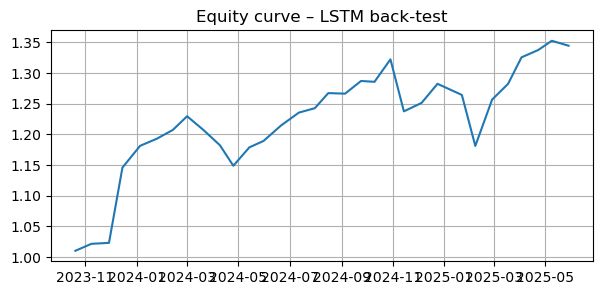

In [27]:
# ───────────────────────────────────────────────────────────────────────────────
#  DIAGNÓSTICOS EXPRESS  · Back-test cargado en «res_df»
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, joblib, yfinance as yf, matplotlib.pyplot as plt
plt.style.use("default")

bt_df = res_df.copy()               # ← tu DataFrame del back-test

# 0 ───────── lista de activos ──────────────────────────────────────────────────
def _get_tickers(df: pd.DataFrame) -> list[str]:
    if hasattr(df, "attrs") and "tickers" in df.attrs:
        return df.attrs["tickers"]
    if "tickers" in df.columns:
        return df["tickers"].iloc[0]
    try:
        return joblib.load(cfg.DATA / "processed" / "lstm_data.pkl")["tickers"]
    except Exception:
        n = len(df["r_hat"].iloc[0])
        return [f"asset_{i}" for i in range(n)]

tickers = _get_tickers(bt_df)
assert len(tickers) == len(bt_df["r_hat"].iloc[0]), \
       f"tickers({len(tickers)}) ≠ r_hat({len(bt_df['r_hat'].iloc[0])})"

# 1 ───────── r̂ en DataFrame numérico ─────────────────────────────────────────
rhat_df = pd.DataFrame(
    np.vstack(bt_df["r_hat"].values), index=bt_df.index, columns=tickers
).astype(float)

print("\n════════  DIAGNÓSTICO RÁPIDO DEL BACK-TEST  ════════")
print("\n── r̂  (target diario) – mira que |max| ≤ 0.05 ──")
stats = rhat_df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
cols  = [c for c in ["mean","std","min","1%","99%","max"] if c in stats.columns]
print(stats[cols])

# 2 ───────── pesos ────────────────────────────────────────────────────────────
w_df = pd.DataFrame(
    np.vstack(bt_df["w_star"].values), index=bt_df.index, columns=tickers
).astype(float)

print("\n── Suma de pesos (debe≈1) ──")
print(w_df.sum(axis=1).describe())

print("\n── Máx |peso| observado ──")
print(w_df.abs().max().sort_values(ascending=False).head())

# 3 ───────── rebals con |ret_bruto| > 10 % ─────────────────────────────────────
thr = 0.10
outs = bt_df.loc[bt_df["ret_bruto"].abs() > thr, ["ret_bruto","turnover"]]
print(f"\n── Rebals con |ret_bruto| > {thr:.0%} = {len(outs)} ──")
print(outs.head())

# 4 ───────── prueba de look-ahead frente al SPY ───────────────────────────────
start = bt_df.index.min()
end   = bt_df.index.max() + pd.Timedelta(days=1)

spy_px  = yf.download("SPY", start=start, end=end,
                      progress=False, auto_adjust=False)["Adj Close"].ffill()
spy_ret = np.log(spy_px / spy_px.shift(1))

com      = rhat_df.index.intersection(spy_ret.index)
mean_sig = rhat_df.loc[com].mean(axis=1)
spy_algn = spy_ret.loc[com]

tmp1 = pd.concat([mean_sig,        spy_algn.shift(-1)], axis=1).dropna()
tmp2 = pd.concat([mean_sig.shift(1), spy_algn        ], axis=1).dropna()

c1 = tmp1.iloc[:,0].corr(tmp1.iloc[:,1])     # r̂_t   vs  SPY_{t+1}
c2 = tmp2.iloc[:,0].corr(tmp2.iloc[:,1])     # r̂_(t-1) vs  SPY_t
print(f"\n── Look-ahead check ──  corr(r̂_t , SPY_(t+1)) = {c1:.3f}   "
      f"corr(r̂_(t-1), SPY_t) = {c2:.3f}")

# 5 ───────── curva de capital ─────────────────────────────────────────────────
wealth = (1 + bt_df["ret_bruto"].values).cumprod()
plt.figure(figsize=(7,3))
plt.plot(bt_df.index, wealth)
plt.title("Equity curve – LSTM back-test")
plt.grid(True); plt.show()
